# This notebook implements the MI estimation of section 5.B in 
# https://arxiv.org/abs/2012.11197

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input
from keras import optimizers

# Utils function 


In [3]:
# convert class to one hot 
def convert_to_one_hot(y):
    dict_size = np.unique(y).shape[0]
    y_hot = np.eye(dict_size)[y.astype('int32')]
    return y_hot

def make_one_hot(y, dims):
    y_hot = []
    for i in range(dims):
        y_hot.append(convert_to_one_hot(y[:, i]))
    return y_hot

In [4]:
# descretize to equa-probability bins
def discretize(data, bins):
    split = np.array_split(np.sort(data), bins)
    cutoffs = [x[-1] for x in split]
    cutoffs = cutoffs[:-1]
    discrete = np.digitize(data, cutoffs, right=True)
    return discrete, cutoffs

def discretize_batch(data, bins, batch_size):
    z_disc = np.zeros((data.shape[0], data.shape[1]))
    for d in range(data.shape[1]):
        z_disc[:, d], _ = discretize(data[:, d], bins)
    return z_disc

# Simulated source

In [5]:
# creating the covariance matrix 
def making_cov(rho, dims):
    cov = np.zeros((2*dims, 2*dims))
    for i in range(dims):
        cov[i, i] = 1
        cov[i+dims, i+dims] = 1
        cov[i, i + dims] = rho
        cov[i + dims, i] = rho
    return cov

def generate_gaussian(rho, batch_size, dims):
    cov = making_cov(rho, dims)
    z = np.random.multivariate_normal(mean=np.repeat(0, dims*2), cov=cov, size=batch_size)
    return z

#  Model definition

In [6]:
# basic fc model with number of losses equales to dims - the dimensions of Y
def model_basic_classification(input_shape, class_size):
    l0 = Input(shape=input_shape, dtype = 'float32', name = 'input_l')
    X = Dense(units=500, kernel_initializer='random_uniform', name = 'l1')(l0)
    X = Dense(units=500, kernel_initializer='random_uniform', name = 'l2')(X)
    X = Dense(units=500, kernel_initializer='random_uniform', name = 'l3')(X)

    output = [Dense(class_size, activation='softmax')(X) for i in range(1) ]
    model = Model(input = [l0], outputs =  output )
    return model

In [7]:
# Initialize entropy models
bins = 250
dims = 20

model_lst = []
opt_lst = []
for m in range(0, dims):
    if m == 0:
        model_lst.append(None)
    else:
        model_lst.append(model_basic_classification([m], bins))

for m in range(0, dims):
    if m == 0:
        opt_lst.append(None)
    else:
        opt_lst.append(optimizers.Adam())

for m in range (1, dims):
    model_lst[m].compile(loss='categorical_crossentropy', optimizer=opt_lst[m], metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\shale\Anaconda3\envs\tf_1_15\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if __name__ == '__main__':


In [8]:
# Initialize conditional entropy models

model_lst_cond = []
opt_lst_cond = []
for m in range(0, dims):
    model_lst_cond.append(model_basic_classification([dims+m], bins))

for m in range(0, dims):
    opt_lst_cond.append(optimizers.Adam())

for m in range (0, dims):
    model_lst_cond[m].compile(loss='categorical_crossentropy', optimizer=opt_lst_cond[m], metrics=['accuracy'])

C:\Users\shale\Anaconda3\envs\tf_1_15\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  if __name__ == '__main__':


# Estimating H(X)

In [11]:
# running of different true values of I/rho
r_lst = []
I = np.arange(2, 12, 2)
for i in I:
    r_lst.append((1-np.exp(-2*i/dims))**0.5)

In [12]:
# run 2000 epochs for every rho/MI value 
epochs = 4000
batch_size = 256
sub_loss_lst = []
H_y_lst = [ [] for _ in range(dims)]
H_yx_lst = [ [] for _ in range(dims)]
I_hat = []
H_y_res = []
EMA_SPAN = 200
for r in r_lst:
    for i in range(epochs):
        z_0 = generate_gaussian(r, batch_size, dims)
        for j in range(0, dims):
            if j != 0: # if this is not the first co
                x = z_0[:, range(j)]
                y = z_0[:, j]
                y = np.reshape(y, [-1, 1])
                y = discretize_batch(y, bins, batch_size)
                y_hot = make_one_hot(y, 1)
                hist = model_lst[j].fit(x, y_hot, epochs = 1, batch_size = batch_size, verbose=0)
                H_y_lst[j].append(hist.history['loss'])
            else:
                y = z_0[:, j]
                y = np.reshape(y, [-1, 1])
                y = discretize_batch(y, bins, batch_size)
                _, p_1 = np.unique(y, return_counts=True)
                p_1 = p_1/(p_1.sum() + 10**-5) 
                H_y_lst[j].append(-np.sum(np.array(p_1)*np.log(p_1)) + (pd.DataFrame(y).nunique()-1)/(2*batch_size)) # MM mi estimator
            x = z_0[:, range(dims+j)]
            y = z_0[:, dims+j]
            y = np.reshape(y, [-1, 1])
            y = discretize_batch(y, bins, batch_size)
            y_hot = make_one_hot(y, 1)
            hist = model_lst_cond[j].fit(x, y_hot, epochs = 1, batch_size = batch_size, verbose=0)
            H_yx_lst[j].append(hist.history['loss'])
            
        H_y = pd.Series(np.reshape(np.sum(H_y_lst, axis=0), [-1]))
        H_yx = pd.Series(np.reshape(np.sum(H_yx_lst, axis=0), [-1]))
        I_hat.append(H_y.iloc[-1] - H_yx.iloc[-1])

4.983249344357461 0.7950600976206501 0
5.349382080563515 0.7950600976206501 1
5.771033205517739 0.7950600976206501 2
6.095231689938515 0.7950600976206501 3
6.102855600842446 0.7950600976206501 4
6.4489874024476705 0.7950600976206501 5
6.412169613369912 0.7950600976206501 6
6.6637629647340475 0.7950600976206501 7
6.508264936932534 0.7950600976206501 8
6.816688217648476 0.7950600976206501 9
6.8423377652253805 0.7950600976206501 10
7.7288569588746725 0.7950600976206501 11
7.319208063611001 0.7950600976206501 12
8.151485361584633 0.7950600976206501 13
7.347604431637734 0.7950600976206501 14
7.692563929089516 0.7950600976206501 15
8.108917631634682 0.7950600976206501 16
7.03324262095353 0.7950600976206501 17
7.724311985501259 0.7950600976206501 18
7.413027920254677 0.7950600976206501 19
7.874501862057656 0.7950600976206501 20
7.9314467091645895 0.7950600976206501 21
7.790318884381264 0.7950600976206501 22
8.302608170041054 0.7950600976206501 23
8.45188013506791 0.7950600976206501 24
7.80285

8.395703472622841 0.7950600976206501 203
8.223317303189248 0.7950600976206501 204
8.912933268078774 0.7950600976206501 205
8.762742437848061 0.7950600976206501 206
8.76273766947648 0.7950600976206501 207
8.700858749875039 0.7950600976206501 208
8.598357357510537 0.7950600976206501 209
8.400266565808266 0.7950600976206501 210
8.655454554089516 0.7950600976206501 211
9.202888884076089 0.7950600976206501 212
8.738438047894448 0.7950600976206501 213
8.625733294018715 0.7950600976206501 214
8.573033012875527 0.7950600976206501 215
8.777793564328164 0.7950600976206501 216
8.180606760510415 0.7950600976206501 217
8.040588297375649 0.7950600976206501 218
8.820051588543862 0.7950600976206501 219
9.207286991604775 0.7950600976206501 220
9.271387018689126 0.7950600976206501 221
9.055619873532265 0.7950600976206501 222
9.156983532437295 0.7950600976206501 223
8.891917624005288 0.7950600976206501 224
8.76826492739579 0.7950600976206501 225
9.273841776379555 0.7950600976206501 226
9.235288061627358 

9.654409565457314 0.7950600976206501 404
9.714932837017983 0.7950600976206501 405
8.536497749814004 0.7950600976206501 406
8.865360178479165 0.7950600976206501 407
8.446200527676552 0.7950600976206501 408
8.524900593289345 0.7950600976206501 409
9.41196576548478 0.7950600976206501 410
8.287234701642006 0.7950600976206501 411
9.599482216366738 0.7950600976206501 412
8.841990866192788 0.7950600976206501 413
8.49052850199601 0.7950600976206501 414
8.658873714932412 0.7950600976206501 415
8.919635214337319 0.7950600976206501 416
9.727568783291787 0.7950600976206501 417
9.634034313687295 0.7950600976206501 418
9.828538336285561 0.7950600976206501 419
8.909007467755288 0.7950600976206501 420
8.902103819378823 0.7950600976206501 421
8.887783445843667 0.7950600976206501 422
9.158857979306191 0.7950600976206501 423
8.128430523404091 0.7950600976206501 424
9.578762688168496 0.7950600976206501 425
9.07867924166581 0.7950600976206501 426
8.591004528531045 0.7950600976206501 427
9.088512815960854 0

KeyboardInterrupt: 

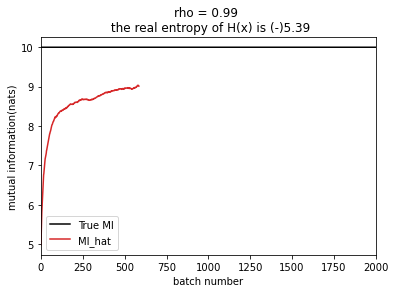

In [13]:
# plot
EMA_SPAN = 200
I_real = np.hstack([np.repeat(i, epochs) for i in I])   
plt.plot(I_real, 'k', label='True MI')
mi = pd.DataFrame(I_hat).clip(lower=0)
mi_smooth = mi.ewm(span=EMA_SPAN).mean()
plt.plot(mi_smooth, 'tab:red', Label = 'MI_hat')
plt.ylabel('mutual information(nats)')
plt.xlabel('batch number')
plt.xlim(0, epochs*len(I))
#plt.ylim(0, I.max()+10)
plt.legend()
plt.title('rho = 0.99 \n the real entropy of H(x) is (-)5.39')
plt.show()